# Prediciting energy efficiency (heating and cooling loads) from building parameters 

dataset
https://archive.ics.uci.edu/ml/datasets/Energy+efficiency

Specifically:

    - X1 Relative Compactness
    - X2 Surface Area
    - X3 Wall Area
    - X4 Roof Area
    - X5 Overall Height
    - X6 Orientation
    - X7 Glazing Area
    - X8 Glazing Area Distribution
    - y1 Heating Load
    - y2 Cooling Load

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

In [17]:
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL, engine='openpyxl')
df = df.sample(frac=1).reset_index(drop=True) #randomizes the data
df = df.dropna(how="all")#remove rows where all cells are empty
df = df.dropna(axis='columns') # drop cols where there's at least one empty cell
df

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.79,637.0,343.0,147.0,7.0,2.0,0.25,4.0,40.00,36.26
2,0.82,612.5,318.5,147.0,7.0,5.0,0.10,1.0,22.58,28.51
3,0.62,808.5,367.5,220.5,3.5,3.0,0.40,3.0,16.35,17.14
4,0.82,612.5,318.5,147.0,7.0,3.0,0.25,2.0,25.98,26.96
5,0.90,563.5,318.5,122.5,7.0,5.0,0.40,4.0,36.57,36.10
...,...,...,...,...,...,...,...,...,...,...
1290,0.62,808.5,367.5,220.5,3.5,2.0,0.25,5.0,13.68,15.19
1291,0.76,661.5,416.5,122.5,7.0,3.0,0.40,1.0,39.97,40.85
1292,0.79,637.0,343.0,147.0,7.0,5.0,0.40,2.0,41.92,48.03
1293,0.69,735.0,294.0,220.5,3.5,5.0,0.10,2.0,11.49,13.51


In [18]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
X1,768.0,0.764167,0.105777,0.62,0.6825,0.75,0.8300,0.98
X2,768.0,671.708333,88.086116,514.50,606.3750,673.75,741.1250,808.50
X3,768.0,318.500000,43.626481,245.00,294.0000,318.50,343.0000,416.50
X4,768.0,176.604167,45.165950,110.25,140.8750,183.75,220.5000,220.50
X5,768.0,5.250000,1.751140,3.50,3.5000,5.25,7.0000,7.00
X6,768.0,3.500000,1.118763,2.00,2.7500,3.50,4.2500,5.00
X7,768.0,0.234375,0.133221,0.00,0.1000,0.25,0.4000,0.40
X8,768.0,2.812500,1.550960,0.00,1.7500,3.00,4.0000,5.00
Y1,768.0,22.307195,10.090204,6.01,12.9925,18.95,31.6675,43.10
Y2,768.0,24.587760,9.513306,10.90,15.6200,22.08,33.1325,48.03


In [20]:
# checking for empty elements
df.isna().sum()

X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
X7    0
X8    0
Y1    0
Y2    0
dtype: int64

In [32]:
# Prep dataset for training
train_ds, test_ds = train_test_split(df, test_size=0.1)# 10% testing and 90% train and val
# train_ds, val_ds = train_test_split(train_ds, test_size=0.2) #model.fit will handle validation split


In [34]:
# print(f"training size = {train_ds['X1'].size}\nval size = {val_ds['X1'].size}\ntesting size = {test_ds['X1'].size}\n ")
print(f"training size = {train_ds['X1'].size}\ntesting size = {test_ds['X1'].size}\n ")

training size = 691
testing size = 77
 


In [39]:
def extract_y(data):
    y1 = np.array(data.pop('Y1'))
    y2 = np.array(data.pop('Y2'))
    return (y1, y2)

In [ ]:
train_ys =  extract_y(train_ds)
test_ys = extract_y(test_ds)

In [40]:
train_ds # notice how we removed Y1 and Y2

,X1,X2,X3,X4,X5,X6,X7,X8
886,0.82,612.5,318.5,147.00,7.0,5.0,0.40,1.0
913,0.86,588.0,294.0,147.00,7.0,4.0,0.25,5.0
482,0.69,735.0,294.0,220.50,3.5,4.0,0.40,5.0
117,0.98,514.5,294.0,110.25,7.0,5.0,0.40,1.0
143,0.90,563.5,318.5,122.50,7.0,2.0,0.25,2.0
...,...,...,...,...,...,...,...,...
763,0.90,563.5,318.5,122.50,7.0,2.0,0.10,4.0
102,0.66,759.5,318.5,220.50,3.5,5.0,0.40,1.0
366,0.71,710.5,269.5,220.50,3.5,3.0,0.25,5.0
602,0.79,637.0,343.0,147.00,7.0,5.0,0.10,2.0


In [46]:
# build the model
def build_model():
    in_shape = len(train_ds.columns)
    nonlinear_activation_function = 'relu'

    inputs = Input(shape=(in_shape))
    first_dense = Dense(128, name='first_dense', activation=nonlinear_activation_function)(inputs)
    second_dense = Dense(128, name='second_dense', activation=nonlinear_activation_function)(first_dense)

    # we will get the first regression output here
    y1_output = Dense(1, name='y1_output')(second_dense)

    # second output will be obtained after an extra dense
    third_dense = Dense(128, name="third_dense", activation=nonlinear_activation_function)(second_dense)
    y2_output = Dense(1, name='y2_output')(third_dense)

    model = Model(inputs=inputs, outputs=[y1_output, y2_output])
    return model




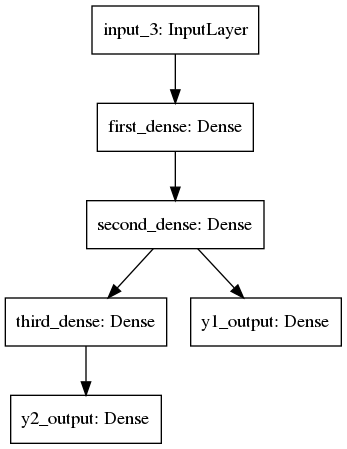

In [48]:
model_1 = build_model()
tf.keras.utils.plot_model(model_1)

In [49]:
model_1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
first_dense (Dense)             (None, 128)          1152        input_3[0][0]                    
__________________________________________________________________________________________________
second_dense (Dense)            (None, 128)          16512       first_dense[0][0]                
__________________________________________________________________________________________________
third_dense (Dense)             (None, 128)          16512       second_dense[0][0]               
____________________________________________________________________________________________

In [82]:
def compile_model(model):
    optimizer = tf.keras.optimizers.Adam()

    loss = {'y1_output':'mse', 'y2_output':'mse'}
    # you nneed to use two different instnaces
    metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()}

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [83]:
compile_model(model_1)

In [84]:
callbacks = tf.keras.callbacks.EarlyStopping(patience=20)
epochs = 500


In [85]:
def norm(x):
    return (x - x.mean()) / x.std()


train_ds = norm(train_ds)
train_ys = (norm(train_ys[0]), norm(train_ys[1]))
test_ds = norm(test_ds)
test_ys = (norm(test_ys[0]), norm(test_ys[1]))

In [86]:
history_1 = model_1.fit(x=train_ds, y=train_ys, validation_split=0.2, epochs=epochs, callbacks=callbacks)

Epoch 1/500
18/18 [==============================] - 1s 12ms/step - loss: 0.1608 - y1_output_loss: 0.0537 - y2_output_loss: 0.1070 - y1_output_root_mean_squared_error: 0.2318 - y2_output_root_mean_squared_error: 0.3272 - val_loss: 0.0984 - val_y1_output_loss: 0.0383 - val_y2_output_loss: 0.0601 - val_y1_output_root_mean_squared_error: 0.1958 - val_y2_output_root_mean_squared_error: 0.2451
Epoch 2/500
18/18 [==============================] - 0s 5ms/step - loss: 0.0764 - y1_output_loss: 0.0320 - y2_output_loss: 0.0444 - y1_output_root_mean_squared_error: 0.1788 - y2_output_root_mean_squared_error: 0.2107 - val_loss: 0.0596 - val_y1_output_loss: 0.0233 - val_y2_output_loss: 0.0363 - val_y1_output_root_mean_squared_error: 0.1528 - val_y2_output_root_mean_squared_error: 0.1905
Epoch 3/500
18/18 [==============================] - 0s 5ms/step - loss: 0.0472 - y1_output_loss: 0.0171 - y2_output_loss: 0.0301 - y1_output_root_mean_squared_error: 0.1309 - y2_output_root_mean_squared_error: 0.1734

In [87]:
# print(history_1.history.keys())
#test losses
result = model_1.evaluate(test_ds, test_ys, return_dict=True)

3/3 [==============================] - 0s 3ms/step - loss: 0.0920 - y1_output_loss: 0.0230 - y2_output_loss: 0.0690 - y1_output_root_mean_squared_error: 0.1516 - y2_output_root_mean_squared_error: 0.2627


In [88]:
result

{'loss': 0.09200384467840195,
 'y1_output_loss': 0.022969044744968414,
 'y2_output_loss': 0.06903479993343353,
 'y1_output_root_mean_squared_error': 0.15155541896820068,
 'y2_output_root_mean_squared_error': 0.2627447545528412}

In [151]:
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-1.7, 40], [-0.3, 10])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history_1.history[metric_name], color='blue', label=metric_name)
    plt.plot(history_1.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.legend()
    plt.show()

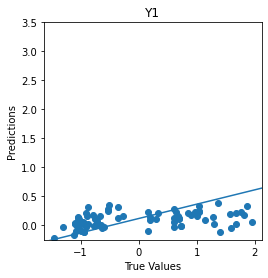

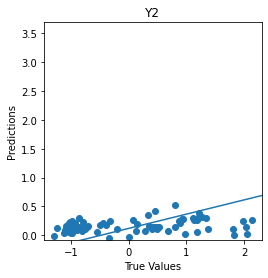

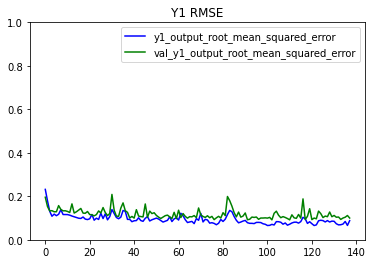

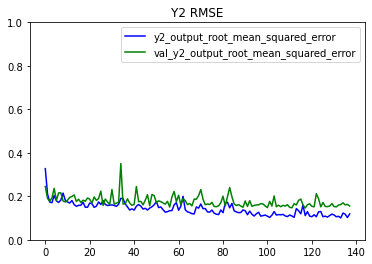

In [152]:

# Plot the loss and mse
Y_pred = model.predict(test_ds)
plot_diff(test_ys[0], Y_pred[0], title='Y1')
plot_diff(test_ys[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=1)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=1)

